In [13]:
import numpy as np
from PIL import Image
import cv2
import os
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import warnings
warnings.filterwarnings('ignore')
import random
from tabulate import tabulate
from tqdm import tqdm
import pandas as pd
from scipy.stats import kurtosis, skew, iqr, norm, t, laplace, beta, multivariate_normal
from collections import Counter
np.set_printoptions(suppress=True)
from mpl_toolkits.mplot3d import Axes3D 

In [14]:
n_images = 250
images = []

while len(images) != n_images:
    idx = random.randint(14, 25000)
    image_name = f'im{idx}.jpg'
    image = cv2.imread(glob.glob(f'./images/mirflickr/{image_name}')[0])[:, :, 1]
    #images.append((image_name, image))
    images.append(image)
    
images = np.asarray(images)
assert len(images) == n_images

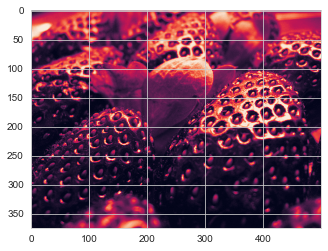

In [15]:
plt.imshow(images[0]);

# Для зеленого каналу кольору тестових зображень обчислити наступні характеристики розподілу значень яскравості пікселів:
 - Математичне очікування та дисперсію
 - Медіану та інтерквартильний розмах
 - Коефіцієнти асиметрії та ексцесу (нормалізований)
 - Гістограму значень яскравості пікселів (нормалізовану)

In [16]:
def count_statistics(img):
    math_exp_ = np.mean(img)
    variance_ = np.var(img)
    median_ = np.median(img)
    IQR_ = iqr(img.reshape(-1))
    kurtosis_ = kurtosis(img.reshape(-1))
    skew_ = skew(img.reshape(-1))
    return math_exp_, variance_, median_, IQR_, kurtosis_, skew_

In [17]:
def plot_hist(image, distribution_label = None):
    f, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True);
    plt.figure(figsize=(10, 6));
    sns.distplot(image.reshape(-1), kde=False, ax=axes[0]);
    if distribution_label == 't':
        sns.distplot(image.reshape(-1), fit=t, kde=False, ax=axes[1]);
    elif distribution_label == 'beta':
        sns.distplot(image.reshape(-1), fit=beta, kde=False, ax=axes[1]);
    elif distribution_label == 'laplace':
        sns.distplot(image.reshape(-1), fit=laplace, kde=False, ax=axes[1]);
    elif distribution_label == 'norm':
        sns.distplot(image.reshape(-1), fit=norm, kde=False, ax=axes[1]);
    plt.show();

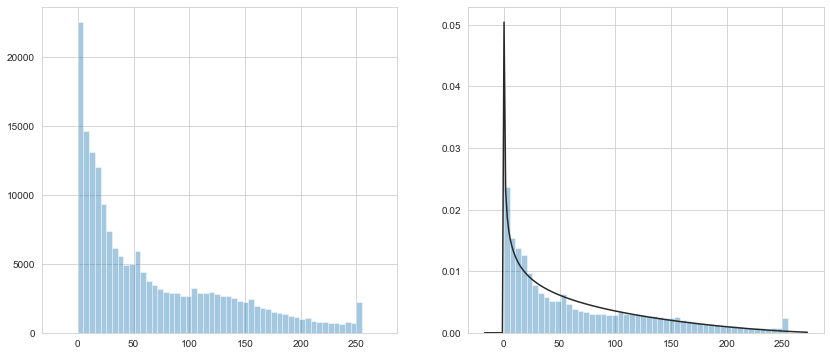

<Figure size 720x432 with 0 Axes>

In [18]:
plot_hist(images[0], 'beta');

# Провести обробку отриманих гістограм:
 - Провести апроксимацію гістограм з використанням імовірнісних розподілів:
     - Нормального (гаусового) розподілу
     - Розподілу Лапласа
     - Розподілу Стьюдента
     - Бета розподілу
 - Для кожної гістограми визначити найкращий тип апроксимуючого розподілу за критерієм мінімізації середньо квадратичного відхилення;
 - Побудувати розподіл отриманих апроксимацій за видом апроксимуючого розподілу;

In [19]:
def approx_array(img):
    img = img.reshape(-1)
    space = np.linspace(0,255,num=256)
    sse_min = 10**100
    res_distribution = None
    arr = []
    imgLen = len(img)
    counter = Counter(img)
    
    for i in range(256):
        arr.append(counter[i])
    
    for i in range(256):
        arr[i]/=imgLen
    
    for distribution in [norm, t, laplace, beta]:
        # fit dist to data
        params = distribution.fit(img)

        # Separate parts of parameters
        arg = params[:-2]
        loc = params[-2]
        scale = params[-1]

        # Calculate fitted PDF and error with fit in distribution
        pdf = distribution.pdf(space, loc=loc, scale=scale, *arg)
            
        sse = np.sum(np.power(arr - pdf, 2.0))
            
        if sse <= sse_min:
            sse_min = sse
            res_distribution = distribution
    
    print(str(res_distribution).split('.')[3].split(' ')[0].split('_')[0])
    return res_distribution, sse_min, str(res_distribution).split('.')[3].split(' ')[0].split('_')[0]

In [20]:
def sample_stats(image):
    math_exp, variance, median, IQR_, kurtosis_, skew_ = count_statistics(image)
    print('=========== stats table ===========')
    print(tabulate([['math expectation', math_exp], 
                ['variance', variance], 
                ['median', median],
                ['IQR', IQR_],
                ['kurtosis', kurtosis_], 
                ['skew', skew_]]))
    
    distribution, sse, distribution_label = approx_array(image)
    print('=========== distribution approximation =========')
    print('distribution : ', distribution_label)
    print('squared error : ', sse)
    
    print('=========== Plotting graph =========')
    plot_hist(image, distribution_label)

61
=========== stats table ===========
----------------  ----------
math expectation   148.052
variance          7693.51
median             186
IQR                155
kurtosis            -1.25849
skew                -0.52848
----------------  ----------
laplace
=========== distribution approximation =========
distribution :  laplace
squared error :  0.00838561063064266
=========== Plotting graph =========


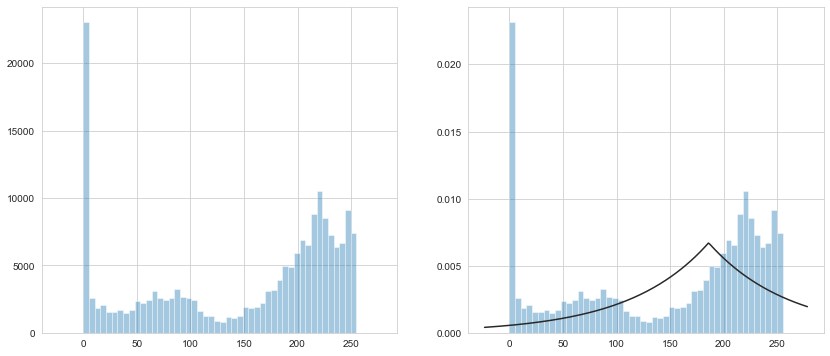

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
17
=========== stats table ===========
----------------  ----------
math expectation   120.528
variance          6986.16
median             139
IQR                172
kurtosis            -1.56262
skew                -0.1933
----------------  ----------
norm
=========== distribution approximation =========
distribution :  norm
squared error :  0.004248477005033658
=========== Plotting graph =========


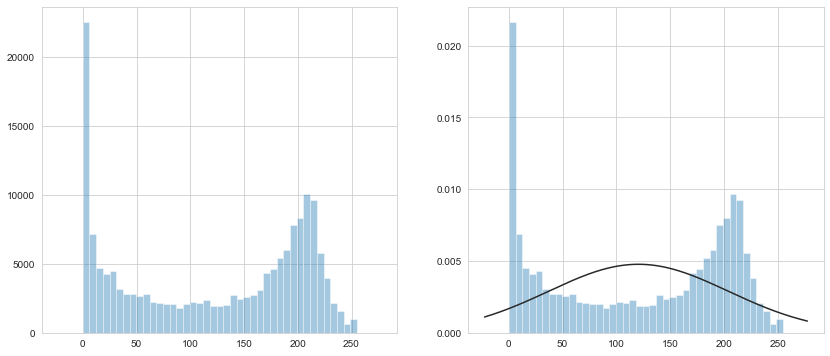

<Figure size 720x432 with 0 Axes>

************************************************************************************************************
133
=========== stats table ===========
----------------  -----------
math expectation    89.5004
variance          1835.95
median              94
IQR                 66
kurtosis            -0.834492
skew                -0.215477
----------------  -----------
beta
=========== distribution approximation =========
distribution :  beta
squared error :  0.0002981994080282176
=========== Plotting graph =========


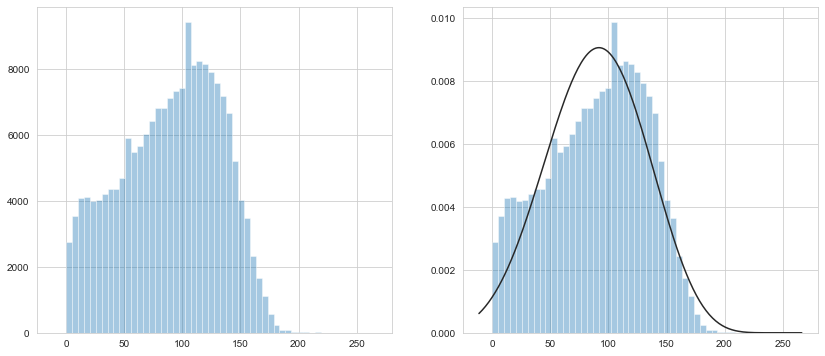

<Figure size 720x432 with 0 Axes>

************************************************************************************************************


In [21]:
n_samples = 3
for image_idx in np.random.choice(250, n_samples):
    print(image_idx)
    sample_stats(images[image_idx])
    print('******************************************************'*2)

In [ ]:
normalCount = 0
tCount = 0
laplaceCount = 0
betaCount = 0

for i in tqdm(range(250), desc='Progress'):
    distName = approx_array(images[i])[2]
    if(distName == 'norm'):
        normalCount+=1
    elif(distName == 't'):
        tCount+=1
    elif(distName == 'laplace'):
        laplaceCount+=1
    elif(distName == 'beta'):
        betaCount+=1

print('The distribution of the approximations:')
print('Normal distribution:', normalCount, 'images')
print('Student distribution:', tCount, 'images')
print('Laplace distribution:', laplaceCount, 'images')
print('Beta distribution:', betaCount, 'images')

Progress:   0%|▎                                                                       | 1/250 [00:11<48:56, 11.79s/it]

laplace


Progress:   1%|▌                                                                       | 2/250 [00:21<45:33, 11.02s/it]

norm


Progress:   1%|▊                                                                       | 3/250 [00:29<41:37, 10.11s/it]

laplace


Progress:   2%|█▏                                                                      | 4/250 [00:38<40:44,  9.94s/it]

laplace


Progress:   2%|█▍                                                                      | 5/250 [00:48<40:33,  9.93s/it]

laplace


Progress:   2%|█▋                                                                      | 6/250 [01:02<45:05, 11.09s/it]

laplace


Progress:   3%|██                                                                      | 7/250 [01:11<42:08, 10.41s/it]

t


Progress:   3%|██▎                                                                     | 8/250 [01:19<40:03,  9.93s/it]

beta


Progress:   4%|██▌                                                                     | 9/250 [01:32<42:49, 10.66s/it]

t


Progress:   4%|██▊                                                                    | 10/250 [01:42<42:39, 10.66s/it]

norm


Progress:   4%|███                                                                    | 11/250 [01:47<35:41,  8.96s/it]

laplace


Progress:   5%|███▍                                                                   | 12/250 [01:56<34:56,  8.81s/it]

beta


Progress:   5%|███▋                                                                   | 13/250 [02:04<34:16,  8.68s/it]

beta


Progress:   6%|███▉                                                                   | 14/250 [02:14<35:53,  9.13s/it]

beta


Progress:   6%|████▎                                                                  | 15/250 [02:25<37:38,  9.61s/it]

t


Progress:   6%|████▌                                                                  | 16/250 [02:38<41:24, 10.62s/it]

beta


Progress:   7%|████▊                                                                  | 17/250 [02:49<41:52, 10.78s/it]

beta


Progress:   7%|█████                                                                  | 18/250 [03:00<41:39, 10.78s/it]

norm


Progress:   8%|█████▍                                                                 | 19/250 [03:07<37:15,  9.68s/it]

beta


Progress:   8%|█████▋                                                                 | 20/250 [03:19<39:29, 10.30s/it]

laplace


Progress:   8%|█████▉                                                                 | 21/250 [03:30<39:42, 10.41s/it]

norm


Progress:   9%|██████▏                                                                | 22/250 [03:37<35:47,  9.42s/it]

laplace


Progress:  13%|█████████                                                              | 32/250 [04:57<30:01,  8.27s/it]

laplace


Progress:  13%|█████████▎                                                             | 33/250 [05:13<37:47, 10.45s/it]

beta


Progress:  14%|█████████▋                                                             | 34/250 [05:25<40:05, 11.14s/it]

norm


Progress:  14%|█████████▉                                                             | 35/250 [05:38<41:48, 11.67s/it]

beta


Progress:  14%|██████████▏                                                            | 36/250 [05:47<38:48, 10.88s/it]

t


Progress:  15%|██████████▌                                                            | 37/250 [05:58<38:23, 10.81s/it]

norm


Progress:  15%|██████████▊                                                            | 38/250 [06:06<35:22, 10.01s/it]

norm


Progress:  16%|███████████                                                            | 39/250 [06:20<39:50, 11.33s/it]

beta


Progress:  16%|███████████▎                                                           | 40/250 [06:32<40:16, 11.51s/it]

laplace


Progress:  16%|███████████▋                                                           | 41/250 [06:46<42:16, 12.13s/it]

laplace


Progress:  17%|███████████▉                                                           | 42/250 [06:53<36:24, 10.50s/it]

t


Progress:  17%|████████████▏                                                          | 43/250 [07:04<36:47, 10.67s/it]

laplace


Progress:  18%|████████████▍                                                          | 44/250 [07:14<36:45, 10.71s/it]

laplace


Progress:  18%|████████████▊                                                          | 45/250 [07:23<34:19, 10.04s/it]

laplace


Progress:  18%|█████████████                                                          | 46/250 [07:31<32:14,  9.48s/it]

laplace


Progress:  19%|█████████████▎                                                         | 47/250 [07:39<30:15,  8.94s/it]

laplace


Progress:  19%|█████████████▋                                                         | 48/250 [07:49<30:55,  9.18s/it]

laplace


Progress:  20%|█████████████▉                                                         | 49/250 [07:59<32:27,  9.69s/it]

laplace


Progress:  20%|██████████████▏                                                        | 50/250 [08:10<33:25, 10.03s/it]

t


Progress:  20%|██████████████▍                                                        | 51/250 [08:19<31:41,  9.56s/it]

norm


Progress:  21%|██████████████▊                                                        | 52/250 [08:26<29:13,  8.85s/it]

beta


Progress:  21%|███████████████                                                        | 53/250 [08:36<29:56,  9.12s/it]

norm


Progress:  22%|███████████████▎                                                       | 54/250 [08:50<34:42, 10.62s/it]

laplace


Progress:  22%|███████████████▌                                                       | 55/250 [08:59<33:00, 10.16s/it]

norm


Progress:  22%|███████████████▉                                                       | 56/250 [09:05<29:02,  8.98s/it]

beta


Progress:  23%|████████████████▏                                                      | 57/250 [09:15<30:10,  9.38s/it]

norm


Progress:  23%|████████████████▍                                                      | 58/250 [09:26<31:35,  9.87s/it]

t


Progress:  24%|████████████████▊                                                      | 59/250 [09:38<33:12, 10.43s/it]

laplace


Progress:  24%|█████████████████                                                      | 60/250 [09:53<37:28, 11.83s/it]

t


Progress:  24%|█████████████████▎                                                     | 61/250 [09:55<27:53,  8.85s/it]

beta


Progress:  25%|█████████████████▌                                                     | 62/250 [10:07<30:15,  9.66s/it]

laplace


Progress:  25%|█████████████████▉                                                     | 63/250 [10:14<27:55,  8.96s/it]

laplace


Progress:  26%|██████████████████▏                                                    | 64/250 [10:30<34:43, 11.20s/it]

t


Progress:  26%|██████████████████▍                                                    | 65/250 [10:37<30:27,  9.88s/it]

laplace


Progress:  26%|██████████████████▋                                                    | 66/250 [10:47<30:37,  9.98s/it]

laplace


Progress:  27%|███████████████████                                                    | 67/250 [10:53<26:34,  8.71s/it]

norm


Progress:  27%|███████████████████▎                                                   | 68/250 [11:01<26:00,  8.58s/it]

beta


Progress:  28%|███████████████████▌                                                   | 69/250 [11:12<27:57,  9.27s/it]

laplace


Progress:  28%|███████████████████▉                                                   | 70/250 [11:23<29:20,  9.78s/it]

t


Progress:  28%|████████████████████▏                                                  | 71/250 [11:34<30:13, 10.13s/it]

laplace


Progress:  30%|█████████████████████▎                                                 | 75/250 [12:16<31:24, 10.77s/it]

laplace


Progress:  30%|█████████████████████▌                                                 | 76/250 [12:26<30:18, 10.45s/it]

beta


Progress:  31%|█████████████████████▊                                                 | 77/250 [12:36<30:10, 10.46s/it]

laplace


Progress:  31%|██████████████████████▏                                                | 78/250 [12:48<31:20, 10.93s/it]

norm


Progress:  32%|██████████████████████▍                                                | 79/250 [13:01<32:41, 11.47s/it]

laplace


Progress:  32%|██████████████████████▋                                                | 80/250 [13:17<36:01, 12.72s/it]

laplace


Progress:  32%|███████████████████████                                                | 81/250 [13:31<37:08, 13.19s/it]

beta


Progress:  33%|███████████████████████▎                                               | 82/250 [13:44<36:37, 13.08s/it]

norm


Progress:  33%|███████████████████████▌                                               | 83/250 [13:55<34:31, 12.41s/it]

beta


Progress:  34%|███████████████████████▊                                               | 84/250 [14:07<33:53, 12.25s/it]

laplace


Progress:  34%|████████████████████████▏                                              | 85/250 [14:16<31:02, 11.29s/it]

beta


Progress:  34%|████████████████████████▍                                              | 86/250 [14:18<23:32,  8.61s/it]

laplace


Progress:  35%|████████████████████████▋                                              | 87/250 [14:28<24:17,  8.94s/it]

norm


Progress:  35%|████████████████████████▉                                              | 88/250 [14:35<22:53,  8.48s/it]

beta


Progress:  36%|█████████████████████████▎                                             | 89/250 [14:44<23:12,  8.65s/it]

norm


Progress:  36%|█████████████████████████▌                                             | 90/250 [14:55<24:43,  9.27s/it]

t


Progress:  38%|██████████████████████████▋                                            | 94/250 [15:32<24:15,  9.33s/it]

norm


Progress:  38%|██████████████████████████▉                                            | 95/250 [15:38<22:07,  8.56s/it]

beta


Progress:  38%|███████████████████████████▎                                           | 96/250 [15:49<23:54,  9.32s/it]

beta


Progress:  39%|███████████████████████████▌                                           | 97/250 [15:58<23:00,  9.02s/it]

norm


Progress:  39%|███████████████████████████▊                                           | 98/250 [16:06<22:30,  8.89s/it]

beta


Progress:  40%|████████████████████████████                                           | 99/250 [16:17<23:58,  9.53s/it]

beta


Progress:  40%|████████████████████████████                                          | 100/250 [16:31<27:10, 10.87s/it]

beta


Progress:  40%|████████████████████████████▎                                         | 101/250 [16:39<24:44,  9.96s/it]

t


Progress:  41%|████████████████████████████▌                                         | 102/250 [16:59<32:02, 12.99s/it]

norm


Progress:  42%|█████████████████████████████▋                                        | 106/250 [17:47<27:29, 11.45s/it]

laplace


Progress:  43%|█████████████████████████████▉                                        | 107/250 [18:07<33:22, 14.00s/it]

t


Progress:  43%|██████████████████████████████▏                                       | 108/250 [18:22<33:59, 14.36s/it]

laplace


Progress:  44%|██████████████████████████████▌                                       | 109/250 [18:34<31:36, 13.45s/it]

laplace


Progress:  44%|██████████████████████████████▊                                       | 110/250 [18:43<28:21, 12.15s/it]

t


Progress:  44%|███████████████████████████████                                       | 111/250 [18:54<27:13, 11.75s/it]

norm


Progress:  45%|███████████████████████████████▎                                      | 112/250 [19:04<25:56, 11.28s/it]

beta


Progress:  45%|███████████████████████████████▋                                      | 113/250 [19:15<25:53, 11.34s/it]

laplace


Progress:  46%|███████████████████████████████▉                                      | 114/250 [19:32<28:58, 12.78s/it]

laplace


Progress:  46%|████████████████████████████████▏                                     | 115/250 [19:40<26:05, 11.60s/it]

laplace


Progress:  46%|████████████████████████████████▍                                     | 116/250 [19:52<25:43, 11.52s/it]

beta


Progress:  47%|████████████████████████████████▊                                     | 117/250 [20:05<26:29, 11.95s/it]

norm


Progress:  47%|█████████████████████████████████                                     | 118/250 [20:26<32:20, 14.70s/it]

t


Progress:  48%|█████████████████████████████████▎                                    | 119/250 [20:38<30:33, 13.99s/it]

beta


Progress:  48%|█████████████████████████████████▌                                    | 120/250 [20:54<31:13, 14.41s/it]

laplace


Progress:  48%|█████████████████████████████████▉                                    | 121/250 [21:10<32:06, 14.93s/it]

laplace


Progress:  49%|██████████████████████████████████▏                                   | 122/250 [21:30<35:04, 16.44s/it]

beta


Progress:  49%|██████████████████████████████████▍                                   | 123/250 [21:42<32:30, 15.36s/it]

beta


Progress:  50%|██████████████████████████████████▋                                   | 124/250 [21:55<30:33, 14.55s/it]

t


Progress:  51%|███████████████████████████████████▊                                  | 128/250 [22:39<23:25, 11.52s/it]

norm


Progress:  52%|████████████████████████████████████                                  | 129/250 [22:51<23:35, 11.70s/it]

t


Progress:  52%|████████████████████████████████████▍                                 | 130/250 [23:09<27:15, 13.63s/it]

laplace


Progress:  52%|████████████████████████████████████▋                                 | 131/250 [23:19<24:56, 12.57s/it]

beta


Progress:  53%|████████████████████████████████████▉                                 | 132/250 [23:28<22:29, 11.43s/it]

laplace


Progress:  53%|█████████████████████████████████████▏                                | 133/250 [23:40<22:59, 11.79s/it]

laplace


Progress:  54%|█████████████████████████████████████▌                                | 134/250 [23:54<23:42, 12.26s/it]

beta


Progress:  54%|█████████████████████████████████████▊                                | 135/250 [24:09<24:56, 13.01s/it]

t


Progress:  54%|██████████████████████████████████████                                | 136/250 [24:21<24:19, 12.80s/it]

laplace


Progress:  55%|██████████████████████████████████████▎                               | 137/250 [24:28<21:09, 11.24s/it]

laplace


Progress:  55%|██████████████████████████████████████▋                               | 138/250 [24:37<19:32, 10.47s/it]

norm


Progress:  56%|██████████████████████████████████████▉                               | 139/250 [24:48<19:48, 10.71s/it]

beta


Progress:  56%|███████████████████████████████████████▏                              | 140/250 [25:03<21:38, 11.80s/it]

norm


Progress:  56%|███████████████████████████████████████▍                              | 141/250 [25:18<23:27, 12.91s/it]

t


Progress:  57%|███████████████████████████████████████▊                              | 142/250 [25:29<21:58, 12.21s/it]

t


Progress:  57%|████████████████████████████████████████                              | 143/250 [25:37<19:47, 11.10s/it]

t


Progress:  58%|████████████████████████████████████████▎                             | 144/250 [25:50<20:26, 11.57s/it]

t


Progress:  58%|████████████████████████████████████████▌                             | 145/250 [25:59<18:45, 10.72s/it]

laplace


Progress:  58%|████████████████████████████████████████▉                             | 146/250 [26:08<17:45, 10.24s/it]

beta


Progress:  59%|█████████████████████████████████████████▏                            | 147/250 [26:17<16:51,  9.82s/it]

laplace


Progress:  59%|█████████████████████████████████████████▍                            | 148/250 [26:26<16:29,  9.70s/it]

beta


Progress:  60%|█████████████████████████████████████████▋                            | 149/250 [26:35<16:00,  9.51s/it]

laplace


Progress:  60%|██████████████████████████████████████████                            | 150/250 [26:42<14:15,  8.55s/it]

laplace


Progress:  60%|██████████████████████████████████████████▎                           | 151/250 [26:49<13:24,  8.12s/it]

beta


Progress:  61%|██████████████████████████████████████████▌                           | 152/250 [26:59<14:32,  8.90s/it]

t


Progress:  61%|██████████████████████████████████████████▊                           | 153/250 [27:04<12:32,  7.76s/it]

beta


Progress:  62%|███████████████████████████████████████████                           | 154/250 [27:13<12:34,  7.86s/it]

beta


Progress:  62%|███████████████████████████████████████████▍                          | 155/250 [27:22<13:11,  8.33s/it]

t


Progress:  62%|███████████████████████████████████████████▋                          | 156/250 [27:33<14:08,  9.03s/it]

t


Progress:  63%|███████████████████████████████████████████▉                          | 157/250 [27:41<13:53,  8.96s/it]

laplace


Progress:  63%|████████████████████████████████████████████▏                         | 158/250 [27:53<14:41,  9.58s/it]

laplace


Progress:  64%|████████████████████████████████████████████▌                         | 159/250 [28:02<14:25,  9.51s/it]

t


Progress:  64%|████████████████████████████████████████████▊                         | 160/250 [28:12<14:38,  9.76s/it]

laplace


Progress:  64%|█████████████████████████████████████████████                         | 161/250 [28:21<14:14,  9.60s/it]

beta


Progress:  65%|█████████████████████████████████████████████▎                        | 162/250 [28:30<13:33,  9.24s/it]

beta


Progress:  65%|█████████████████████████████████████████████▋                        | 163/250 [28:39<13:15,  9.14s/it]

laplace


Progress:  66%|█████████████████████████████████████████████▉                        | 164/250 [28:46<12:28,  8.70s/it]

t


Progress:  66%|██████████████████████████████████████████████▏                       | 165/250 [28:57<13:07,  9.26s/it]

norm


Progress:  66%|██████████████████████████████████████████████▍                       | 166/250 [29:09<14:18, 10.22s/it]

laplace


Progress:  67%|██████████████████████████████████████████████▊                       | 167/250 [29:19<13:48,  9.99s/it]

beta


Progress:  67%|███████████████████████████████████████████████                       | 168/250 [29:36<16:41, 12.21s/it]

laplace


Progress:  68%|███████████████████████████████████████████████▎                      | 169/250 [29:48<16:26, 12.18s/it]

laplace


Progress:  68%|███████████████████████████████████████████████▌                      | 170/250 [30:00<16:12, 12.16s/it]

norm


Progress:  68%|███████████████████████████████████████████████▉                      | 171/250 [30:10<14:57, 11.36s/it]

beta


Progress:  69%|████████████████████████████████████████████████▏                     | 172/250 [30:14<11:50,  9.11s/it]

norm


Progress:  69%|████████████████████████████████████████████████▍                     | 173/250 [30:22<11:15,  8.77s/it]

beta


Progress:  70%|████████████████████████████████████████████████▋                     | 174/250 [30:36<13:04, 10.32s/it]

beta


Progress:  70%|█████████████████████████████████████████████████                     | 175/250 [30:47<13:19, 10.66s/it]

beta


Progress:  70%|█████████████████████████████████████████████████▎                    | 176/250 [30:54<11:36,  9.41s/it]

laplace


Progress:  71%|█████████████████████████████████████████████████▌                    | 177/250 [31:01<10:36,  8.71s/it]

beta


Progress:  71%|█████████████████████████████████████████████████▊                    | 178/250 [31:09<10:17,  8.58s/it]

beta


Progress:  72%|██████████████████████████████████████████████████                    | 179/250 [31:18<10:11,  8.61s/it]

laplace


Progress:  72%|██████████████████████████████████████████████████▍                   | 180/250 [31:27<10:23,  8.90s/it]

laplace


Progress:  72%|██████████████████████████████████████████████████▋                   | 181/250 [31:36<10:12,  8.88s/it]

beta


Progress:  73%|██████████████████████████████████████████████████▉                   | 182/250 [31:47<10:42,  9.45s/it]

laplace


Progress:  73%|███████████████████████████████████████████████████▏                  | 183/250 [31:56<10:24,  9.32s/it]

laplace


Progress:  74%|███████████████████████████████████████████████████▌                  | 184/250 [32:05<10:15,  9.32s/it]

laplace


Progress:  74%|███████████████████████████████████████████████████▊                  | 185/250 [32:14<09:54,  9.14s/it]

beta


Progress:  74%|████████████████████████████████████████████████████                  | 186/250 [32:28<11:11, 10.49s/it]

t


Progress:  75%|████████████████████████████████████████████████████▎                 | 187/250 [32:35<09:54,  9.44s/it]

beta


Progress:  75%|████████████████████████████████████████████████████▋                 | 188/250 [32:48<10:53, 10.54s/it]

norm


Progress:  76%|████████████████████████████████████████████████████▉                 | 189/250 [32:58<10:34, 10.41s/it]

beta


Progress:  76%|█████████████████████████████████████████████████████▏                | 190/250 [33:06<09:40,  9.67s/it]

beta


Progress:  76%|█████████████████████████████████████████████████████▍                | 191/250 [33:15<09:20,  9.49s/it]

beta


Progress:  77%|█████████████████████████████████████████████████████▊                | 192/250 [33:25<09:14,  9.57s/it]

laplace


Progress:  77%|██████████████████████████████████████████████████████                | 193/250 [33:36<09:32, 10.04s/it]

beta


Progress:  78%|██████████████████████████████████████████████████████▎               | 194/250 [33:44<08:50,  9.47s/it]

beta


Progress:  78%|██████████████████████████████████████████████████████▌               | 195/250 [34:01<10:54, 11.90s/it]

t


Progress:  78%|██████████████████████████████████████████████████████▉               | 196/250 [34:08<09:18, 10.34s/it]

beta


Progress:  79%|███████████████████████████████████████████████████████▏              | 197/250 [34:15<08:12,  9.29s/it]

beta


Progress:  79%|███████████████████████████████████████████████████████▍              | 198/250 [34:23<07:48,  9.01s/it]

laplace


Progress:  80%|███████████████████████████████████████████████████████▋              | 199/250 [34:31<07:19,  8.61s/it]

norm


Progress:  80%|████████████████████████████████████████████████████████              | 200/250 [34:39<06:57,  8.35s/it]

beta


Progress:  80%|████████████████████████████████████████████████████████▎             | 201/250 [34:46<06:31,  7.98s/it]

beta


Progress:  81%|████████████████████████████████████████████████████████▌             | 202/250 [34:57<07:08,  8.92s/it]

beta


Progress:  81%|████████████████████████████████████████████████████████▊             | 203/250 [35:13<08:35, 10.97s/it]

laplace


Progress:  82%|█████████████████████████████████████████████████████████             | 204/250 [35:31<10:03, 13.12s/it]

laplace


Progress:  82%|█████████████████████████████████████████████████████████▍            | 205/250 [35:42<09:17, 12.40s/it]

t


Progress:  82%|█████████████████████████████████████████████████████████▋            | 206/250 [35:49<07:55, 10.80s/it]

beta


Progress:  83%|█████████████████████████████████████████████████████████▉            | 207/250 [35:58<07:26, 10.38s/it]

laplace


Progress:  83%|██████████████████████████████████████████████████████████▏           | 208/250 [36:11<07:53, 11.28s/it]

norm


Progress:  84%|██████████████████████████████████████████████████████████▌           | 209/250 [36:21<07:17, 10.68s/it]

beta


Progress:  84%|██████████████████████████████████████████████████████████▊           | 210/250 [36:33<07:25, 11.15s/it]

norm


Progress:  84%|███████████████████████████████████████████████████████████           | 211/250 [36:44<07:15, 11.16s/it]

laplace


Progress:  85%|███████████████████████████████████████████████████████████▎          | 212/250 [36:59<07:46, 12.27s/it]

t


Progress:  85%|███████████████████████████████████████████████████████████▋          | 213/250 [37:07<06:50, 11.10s/it]

laplace


Progress:  86%|███████████████████████████████████████████████████████████▉          | 214/250 [37:19<06:44, 11.23s/it]

laplace


Progress:  86%|████████████████████████████████████████████████████████████▏         | 215/250 [37:34<07:13, 12.38s/it]

norm


Progress:  86%|████████████████████████████████████████████████████████████▍         | 216/250 [37:45<06:50, 12.09s/it]

norm


Progress:  87%|████████████████████████████████████████████████████████████▊         | 217/250 [37:58<06:39, 12.10s/it]

t


Progress:  87%|█████████████████████████████████████████████████████████████         | 218/250 [38:07<06:05, 11.42s/it]

beta


Progress:  88%|█████████████████████████████████████████████████████████████▎        | 219/250 [38:20<06:04, 11.76s/it]

norm


Progress:  88%|█████████████████████████████████████████████████████████████▌        | 220/250 [38:33<06:02, 12.07s/it]

beta


Progress:  88%|█████████████████████████████████████████████████████████████▉        | 221/250 [38:47<06:08, 12.71s/it]

beta


Progress:  89%|██████████████████████████████████████████████████████████████▏       | 222/250 [38:58<05:43, 12.26s/it]

beta


Progress:  89%|██████████████████████████████████████████████████████████████▍       | 223/250 [39:09<05:22, 11.94s/it]

norm


Progress:  90%|██████████████████████████████████████████████████████████████▋       | 224/250 [39:24<05:32, 12.78s/it]

norm


Progress:  90%|███████████████████████████████████████████████████████████████       | 225/250 [39:32<04:43, 11.35s/it]

laplace


Progress:  90%|███████████████████████████████████████████████████████████████▎      | 226/250 [39:43<04:27, 11.13s/it]

beta


Progress:  91%|███████████████████████████████████████████████████████████████▌      | 227/250 [39:54<04:20, 11.33s/it]

t


Progress:  91%|███████████████████████████████████████████████████████████████▊      | 228/250 [40:00<03:31,  9.61s/it]

laplace


Progress:  92%|████████████████████████████████████████████████████████████████      | 229/250 [40:11<03:32, 10.10s/it]

t


Progress:  92%|████████████████████████████████████████████████████████████████▍     | 230/250 [40:23<03:31, 10.57s/it]

t


Progress:  92%|████████████████████████████████████████████████████████████████▋     | 231/250 [40:35<03:28, 10.99s/it]

laplace


Progress:  93%|████████████████████████████████████████████████████████████████▉     | 232/250 [40:51<03:42, 12.36s/it]

beta


Progress:  93%|█████████████████████████████████████████████████████████████████▏    | 233/250 [41:03<03:29, 12.31s/it]

t


Progress:  94%|█████████████████████████████████████████████████████████████████▌    | 234/250 [41:18<03:30, 13.13s/it]

t


Progress:  94%|█████████████████████████████████████████████████████████████████▊    | 235/250 [41:32<03:20, 13.39s/it]

t


Progress:  94%|██████████████████████████████████████████████████████████████████    | 236/250 [41:40<02:45, 11.82s/it]

norm


Progress:  95%|██████████████████████████████████████████████████████████████████▎   | 237/250 [41:57<02:53, 13.38s/it]

t


Progress:  95%|██████████████████████████████████████████████████████████████████▋   | 238/250 [42:09<02:36, 13.07s/it]

laplace


Progress:  96%|██████████████████████████████████████████████████████████████████▉   | 239/250 [42:20<02:15, 12.34s/it]

norm


Progress:  96%|███████████████████████████████████████████████████████████████████▏  | 240/250 [42:34<02:07, 12.78s/it]

t


Progress:  96%|███████████████████████████████████████████████████████████████████▍  | 241/250 [42:46<01:53, 12.56s/it]

laplace


Progress:  97%|███████████████████████████████████████████████████████████████████▊  | 242/250 [42:54<01:31, 11.38s/it]

laplace


Progress:  97%|████████████████████████████████████████████████████████████████████  | 243/250 [43:10<01:29, 12.76s/it]

laplace


Progress:  98%|████████████████████████████████████████████████████████████████████▎ | 244/250 [43:22<01:14, 12.44s/it]

t


Progress:  98%|████████████████████████████████████████████████████████████████████▌ | 245/250 [43:39<01:09, 13.84s/it]

norm


Progress:  98%|████████████████████████████████████████████████████████████████████▉ | 246/250 [43:52<00:54, 13.64s/it]

beta


Progress:  99%|█████████████████████████████████████████████████████████████████████▏| 247/250 [44:00<00:35, 11.99s/it]

laplace


Progress:  99%|█████████████████████████████████████████████████████████████████████▍| 248/250 [44:10<00:22, 11.18s/it]

beta


Progress: 100%|█████████████████████████████████████████████████████████████████████▋| 249/250 [44:21<00:11, 11.19s/it]

In [23]:
print('The distribution of the approximations:')
print('Normal distribution:', normalCount, 'images')
print('Student distribution:', tCount, 'images')
print('Laplace distribution:', laplaceCount, 'images')
print('Beta distribution:', betaCount, 'images')

The distribution of the approximations:
Normal distribution: 43 images
Student distribution: 48 images
Laplace distribution: 83 images
Beta distribution: 76 images


(array([43., 48., 83., 76.]),
 array([-0.5,  0.5,  1.5,  2.5,  3.5]),
 <a list of 4 Patch objects>)

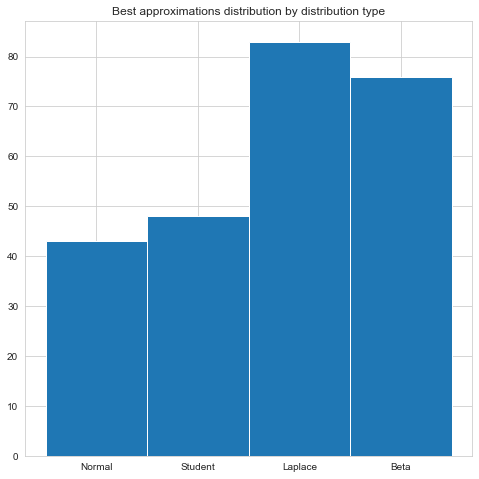

In [24]:
plt.figure(figsize=(8,8))
plt.title('Best approximations distribution by distribution type')
plt.hist(['Normal','Student','Laplace','Beta'], bins=np.arange(5)-0.5, weights = [normalCount, tCount, laplaceCount, betaCount])

# Побудувати багатовимірні гаусові моделі
Сформувати вектори параметрів розподілу значень яскравості пікселів тестових зображень:
 - Математичне очікування
 - Математичне очікування та дисперсія
 - Математичне очікування, дисперсія та коефіцієнт асиметрії
 - Математичне очікування, дисперсія, коефіцієнти асиметрії та ексцесу

In [34]:
def group_statistics(data):
    math_exp_arr = []
    var_arr = []
    skew_arr = []
    kurt_arr = []
    for image in data:
        image_stats = count_statistics(image)
        math_exp_arr.append(image_stats[0])
        var_arr.append(image_stats[1])
        skew_arr.append(image_stats[4])
        kurt_arr.append(image_stats[5])
    return math_exp_arr, var_arr, skew_arr, kurt_arr

In [35]:
math_exp, var, skew, kurt = group_statistics(images)

Визначити параметри багатовимірних гаусових моделей для кожної групи векторів, відобразити їх графічно та у вигляді таблиць.

mean_vec:  107.41545217506075
cov_matrix: 
 1673.5359456864308


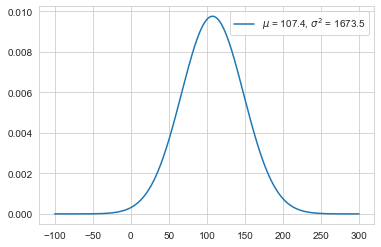

In [36]:
# 1. Math exp 
sample = math_exp
mean_vec_1 = np.mean(sample)
cov_matrix_1 = np.cov(sample)
print('mean_vec: ', mean_vec_1)
print('cov_matrix: \n', cov_matrix_1) 

x = np.linspace(start = -100, stop = 300, num = 2000)
y = norm(mean_vec_1, np.sqrt(cov_matrix_1)).pdf(x)
plt.plot(x, y, label = '$\mu$ = {}, $\sigma^2$ = {}'.format(np.round(mean_vec_1, 1), np.round(cov_matrix_1, 1)))
plt.legend();

mean_vec:  107.41545217506075 4243.408919072519
cov_matrix: 
 [[   1673.53594569   13880.98473311]
 [  13880.98473311 4366445.12780987]]


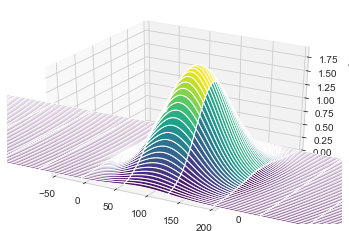

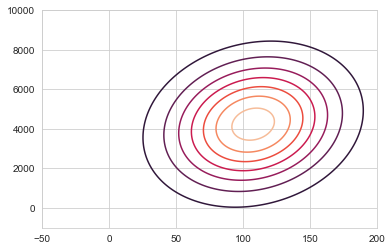

In [37]:
# 2. Math exp, Variance
sample = np.vstack((math_exp, var))
mean_vec_2 = np.mean(sample, axis=1)
cov_matrix_2 = np.cov(sample)
print('mean_vec: ', *mean_vec_2)
print('cov_matrix: \n', cov_matrix_2) 


x, y = np.mgrid[-500:3000, -1000:10000]
position = np.empty(x.shape + (2,))
position[:, :, 0] = x
position[:, :, 1] = y
z = multivariate_normal(mean_vec_2, cov_matrix_2).pdf(position)

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.set_xlim(-50, 200)
ax.set_ylim(-1000, 10000)
ax.plot_surface(x, y, z, cmap='viridis')
plt.show()

plt.xlim(-50, 200)
plt.ylim(-1000, 10000)
plt.contour(x, y, z)
plt.show()

In [38]:
# 3. Math exp, Variance, Skew
sample = np.vstack((math_exp, var, skew))
mean_vec_3 = np.mean(sample, axis=1)
cov_matrix_3 = np.cov(sample)
print('mean_vec: ', *mean_vec_3)
print('cov_matrix: \n', cov_matrix_3) 

mean_vec:  107.41545217506075 4243.408919072519 0.4199595228895673
cov_matrix: 
 [[   1673.53594569   13880.98473311     -29.28626586]
 [  13880.98473311 4366445.12780987   -3078.0709774 ]
 [    -29.28626586   -3078.0709774        9.5595654 ]]


In [39]:
# 4. Math exp, Variance, Skew, Kurtosis
sample = np.vstack((math_exp, var, skew, kurt))
mean_vec_4 = np.mean(sample, axis=1)
cov_matrix_4 = np.cov(sample)
print('mean_vec: ', *mean_vec_4)
print('cov_matrix: \n', cov_matrix_4)               

mean_vec:  107.41545217506075 4243.408919072519 0.4199595228895673 0.27798516994334505
cov_matrix: 
 [[   1673.53594569   13880.98473311     -29.28626586     -38.8191856 ]
 [  13880.98473311 4366445.12780987   -3078.0709774      -91.67834187]
 [    -29.28626586   -3078.0709774        9.5595654        0.94267026]
 [    -38.8191856      -91.67834187       0.94267026       1.14124183]]
